# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')
display(data.head())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
data.describe(include = 'all')

,file_name,real_age
count,7591,7591.000000
unique,7591,NaN
top,006702.jpg,NaN
freq,1,NaN
mean,NaN,31.201159
std,NaN,17.145060
min,NaN,1.000000
25%,NaN,20.000000
50%,NaN,29.000000
75%,NaN,41.000000


In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


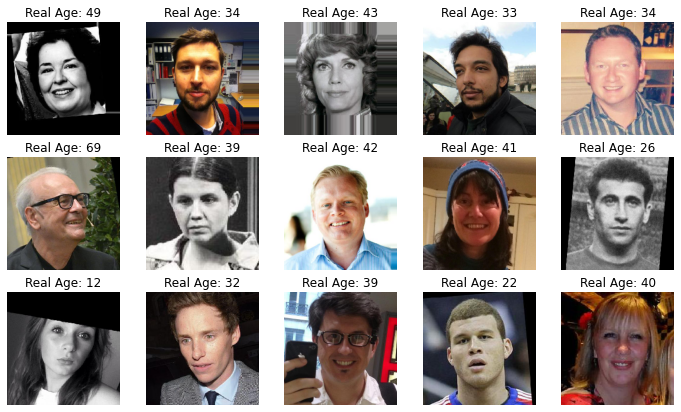

In [8]:
# Получение одного пакета данных из генератора
images, labels = next(train_gen_flow)
# Вывод 15 фотографий с метками на экран
plt.figure(figsize=(12, 12))
for i in range(15):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title('Real Age: {}'.format(labels[i]))
    plt.axis('off')
plt.show()

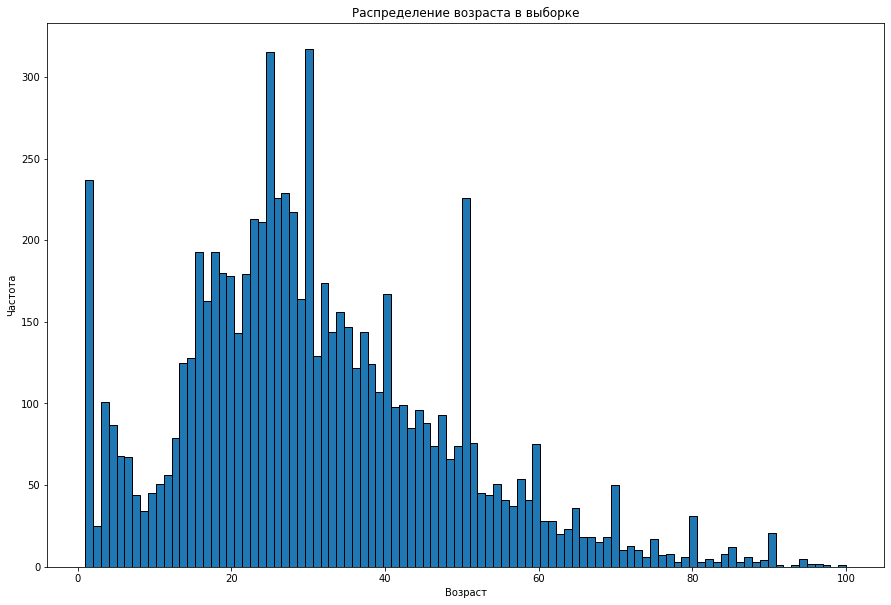

In [6]:
ages = data.real_age
# Гистограмма распределения возраста
plt.figure(figsize=(15, 10))
plt.hist(ages, bins= len(data['real_age'].unique()), edgecolor='black')
# Оси и заголовки графика
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Распределение возраста в выборке')
# Отображение графика
plt.show()

Всего имеется 7591 фотография лиц людей и соответствующий датасет с именем файла фотографии и соответсвующем возрасте человека изображенного на этой фотографии.

Данные распределены неравномерно со средним значением 31.2 и стандартным отклонением 17.14. Наибольшее количество изображений соответствует возрасту младенцев, молодежи ~25 лет и ~36 лет, людей возраста ~45 лет. Гораздо меньше представлены старшие возрастные группы от 60 до 100 лет и особеннос 80 до 100 лет, поэтому можно предположить, что значения ошибки определения возраста лиц пожилых людей будет больше.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import pandas as pd
import numpy as np

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

path = '/datasets/faces/'
labels = pd.read_csv(path +'labels.csv')

def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path +'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345,
        vertical_flip=True) 
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path +'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_datagen_flow
    
def create_model(input_shape):
      
    backbone = ResNet50(input_shape=input_shape,
               weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
               include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))    
    model.add(Flatten())
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', 
              metrics=['mae']) 

    return model 

def train_model(model, train_data, test_data, batch_size=None, epochs=7,
               steps_per_epoch=None,validation_steps= None):

    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model 
# < скопируйте код сюда >

```

Train for 178 steps, validate for 60 steps
Epoch 1/8
178/178 - 48s - loss: 198.9680 - mae: 10.5383 - val_loss: 577.6519 - val_mae: 19.0383
Epoch 2/8
178/178 - 40s - loss: 100.7505 - mae: 7.6176 - val_loss: 357.1818 - val_mae: 14.0396
Epoch 3/8
178/178 - 44s - loss: 63.3892 - mae: 6.0533 - val_loss: 299.8443 - val_mae: 12.9298
Epoch 4/8
178/178 - 50s - loss: 44.1058 - mae: 5.0748 - val_loss: 170.9704 - val_mae: 10.1829
Epoch 5/8
178/178 - 50s - loss: 28.2411 - mae: 4.1264 - val_loss: 111.7483 - val_mae: 7.9804
Epoch 6/8
178/178 - 44s - loss: 20.2151 - mae: 3.4896 - val_loss: 77.5059 - val_mae: 6.6606
Epoch 7/8
178/178 - 47s - loss: 15.2332 - mae: 3.0228 - val_loss: 77.6213 - val_mae: 6.6812
Epoch 8/8
178/178 - 49s - loss: 13.2237 - mae: 2.8147 - val_loss: 87.5942 - val_mae: 7.3071

60/60 - 11s - loss: 87.5942 - mae: 7.3071
Test MAE: 7.3071


## Анализ обученной модели

Согласно условию необходимо было построить и обучить модель для определения возраста человека по его фотографии лица. Среднее абсолютное отклонением (MAE) при этом должно быдо составить не выше 8, то есть, чтобы средняя разница между фактическим значением данных и значением, предсказанным моделью, составляло не более 8 лет.


Исходный  данные представляют собой 7591 фотографию лиц людей и соответствующий датасет с именем файла фотографии и соответсвующем возрасте человека изображенного на этой фотографии. 
Для обучения модели датасет был разделен на тренировочную выборку 75
%, и на тестовую выборку 25%.

**В качестве основы за модель использовал:**

    предобученную нейросеть с архитектурой ResNet50 без замораживания;
    
    тренировочные данные предварительно были аугментированы(техника увеличения количества изображений)  с помощью применения к оригиальным изображениям переворота по вертикали (vertical flip);
    
    в выходном слое, для более точного обучения модели, использовал оптимизацию Adam c шагом обучения 0.0005;
    
    в качестве функции потерь использовалась mean_squared_error, что немного ускорило процесс обучения;
    
С такими параметрами модель была обучена и протестирована на графическом процессоре GPU на 8ми эпохах.  В  результате на финише была достигнута метрика точности модели **MAE = 7.3 лет**. Как видно из отчета работы модели наилучший результат **MAE = 6.66 лет** был достигнут на 6 эпохе, далее показаталь начал увеличиваться, что говорит о процессе переобучения модели. 
В результате требуемая точность предсказания возраста моделью была достигнута, модель можно использовать для предсказаний и для увеличения качества и скорости **достаточно ограничиться 6ю эпохами.**